<a href="https://colab.research.google.com/github/Mariagiusi23/ID-001-AWOL-for-Audio/blob/main/notebook/03_awol_realnvp_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🎯 STEP 1 — Prompt & CLAP Embedding**

**📍 1.1 — Install libraries**

In [2]:
!pip install transformers accelerate torchaudio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00


**📍 1.2 — Import libraries and set device**

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ClapModel, ClapProcessor
from IPython.display import Audio, display
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**📍 1.3 — Load CLAP model and processor**

In [4]:
processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
model_clap = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/614M [00:00<?, ?B/s]

**📍 1.4 — Prompt → Embedding**

In [5]:
prompt = "a soft metallic ringing"
inputs = processor(text=prompt, return_tensors="pt").to(device)
with torch.no_grad():
    embedding = model_clap.get_text_features(**inputs)
embedding = embedding.squeeze()
print("Embedding shape:", embedding.shape)  # Expected: torch.Size([512])

Embedding shape: torch.Size([512])


**📍 1.5 — Embedding visualization**

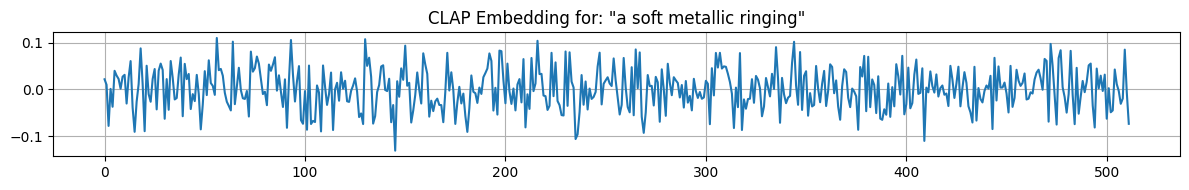

In [6]:
plt.figure(figsize=(12, 2))
plt.plot(embedding.cpu().numpy())
plt.title(f"CLAP Embedding for: \"{prompt}\"")
plt.grid(True)
plt.tight_layout()
plt.show()

Note: _The initial steps in this notebook (CLAP model loading and embedding) partially overlap with previous notebooks. This is intentional to ensure full standalone execution and to serve as a clean entry point for the RealNVP-based contribution._


#**🎯 STEP 2 — RealNVP Model Definition**

**📍 2.1 — Define Coupling Layer for RealNVP**

In [10]:
class CouplingLayer(nn.Module):
    def __init__(self, dim, mask):
        super().__init__()
        self.dim = dim
        self.mask = mask  # Binary vector of shape (dim,)

        hidden = 256
        self.scale_net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
            nn.Tanh()
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = s.sum(dim=1)
        return y, log_det_jacobian

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        return x

**📍 2.2 — Build RealNVP Model with Projection to FM Space**

In [11]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.layers = nn.ModuleList()

        for i in range(n_layers):
            mask = self._get_mask(i)
            self.layers.append(CouplingLayer(input_dim, mask))

        self.projection = nn.Linear(input_dim, output_dim)

    def _get_mask(self, layer_index):
        mask = torch.zeros(self.input_dim)
        if layer_index % 2 == 0:
            mask[: self.input_dim // 2] = 1
        else:
            mask[self.input_dim // 2 :] = 1
        return mask.to(device)

    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det += ldj
        return x, log_det

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return self.projection(z)

# Initialize the model
realnvp = RealNVP(input_dim=512, output_dim=4, n_layers=6).to(device)
print("✅ RealNVP model initialized.")

✅ RealNVP model initialized.


#**🎯 STEP 3 — Supervised Training: Embedding → FM Parameters**

**📍 3.1 — Define training data (same manual prompts as previous notebook)**

In [12]:
train_data = [
    {"prompt": "a high whistle",         "params": [0.888, 0.889, 0.95, 0.67]},
    {"prompt": "a deep rumbling drone",  "params": [0.022, 0.044, 0.60, 0.56]},
    {"prompt": "a mellow flute tone",    "params": [0.378, 0.133, 0.35, 0.44]},
    {"prompt": "a robotic beep",         "params": [0.555, 0.333, 0.80, 0.56]},
    {"prompt": "a soft crackling fire",  "params": [0.167, 0.022, 0.75, 0.33]}
]

**📍 3.2 — Compute embeddings and build dataset**

In [13]:
embeddings = []
targets = []

for example in train_data:
    inputs = processor(text=example["prompt"], return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model_clap.get_text_features(**inputs).squeeze()
    embeddings.append(emb)
    targets.append(torch.tensor(example["params"]))

X = torch.stack(embeddings).to(device)
y = torch.stack(targets).to(device)

# 📍 3.3 — Training loop (MSE on projected inverse)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(realnvp.parameters(), lr=1e-3)
n_epochs = 300

realnvp.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    z, _ = realnvp(X)              # forward pass
    y_pred = realnvp.inverse(z)    # project to FM param space
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {loss.item():.6f}")

print("✅ Training complete.")

Epoch 1/300 — Loss: 0.288972
Epoch 50/300 — Loss: 0.021087
Epoch 100/300 — Loss: 0.002308
Epoch 150/300 — Loss: 0.000288
Epoch 200/300 — Loss: 0.000035
Epoch 250/300 — Loss: 0.000003
Epoch 300/300 — Loss: 0.000000
✅ Training complete.


#**🎯 STEP 4 — Evaluation: Audio Generation and Visualization**

**📍 4.1 — Define synthesis function and audio generation utility**

In [14]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import math


def synthesize(p, sr=16000, duration=2.0):
    t = torch.linspace(0, duration, int(sr * duration))
    carrier, modulator, index, amplitude = p
    mod_signal = torch.sin(2 * math.pi * modulator * t)
    signal = amplitude * torch.sin(2 * math.pi * carrier * t + index * mod_signal)
    return signal


def generate_audio(prompt, model, processor, clap_model, sr=16000, duration=2.0):
    inputs = processor(text=prompt, return_tensors="pt").to(clap_model.device)
    with torch.no_grad():
        embedding = clap_model.get_text_features(**inputs)
        z, _ = model(embedding)
        raw_p = model.inverse(z).squeeze()

    # Rescale to real-world FM ranges
    carrier    = 100 + 900 * raw_p[0]
    modulator  = 50 + 450 * raw_p[1]
    index      = 10 * raw_p[2]
    amplitude  = 0.9 * raw_p[3]
    p = [carrier.item(), modulator.item(), index.item(), amplitude.item()]

    signal = synthesize(p, sr=sr, duration=duration)
    signal_np = signal.numpy()

    print(f"Prompt: {prompt}")
    print(f"  Carrier freq:   {p[0]:.2f} Hz")
    print(f"  Modulator freq: {p[1]:.2f} Hz")
    print(f"  Modulation idx: {p[2]:.2f}")
    print(f"  Amplitude:      {p[3]:.2f}")

    # Plot only the first 0.1s of the waveform for clarity
    plot_duration = 0.1
    plot_samples = int(sr * plot_duration)
    time_axis = np.linspace(0, plot_duration, plot_samples)
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, signal_np[:plot_samples], linewidth=0.3, color='black')
    plt.title("Waveform (first 0.1s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    f, t_spec, Sxx = spectrogram(signal_np, fs=sr, nperseg=512)
    plt.figure(figsize=(10, 4))
    plt.imshow(10 * np.log10(Sxx + 1e-8), aspect='auto', origin='lower',
               extent=[t_spec.min(), t_spec.max(), f.min(), f.max()], cmap='viridis')
    plt.title("Spectrogram (dB)")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

    return Audio(signal_np, rate=sr)


**📍 4.2 — Test the model on training prompts**

Prompt: a high whistle
  Carrier freq:   899.20 Hz
  Modulator freq: 450.05 Hz
  Modulation idx: 9.49
  Amplitude:      0.60


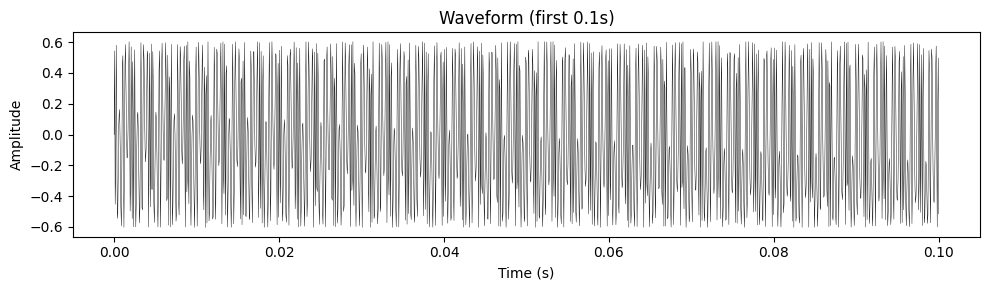

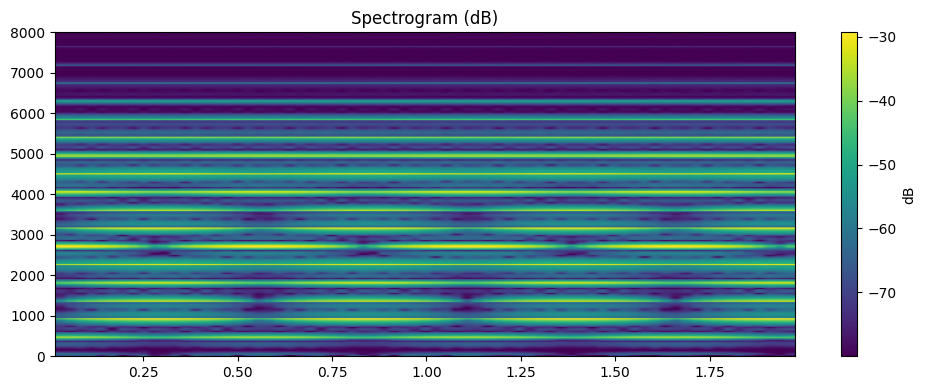

Prompt: a deep rumbling drone
  Carrier freq:   119.80 Hz
  Modulator freq: 69.80 Hz
  Modulation idx: 5.99
  Amplitude:      0.50


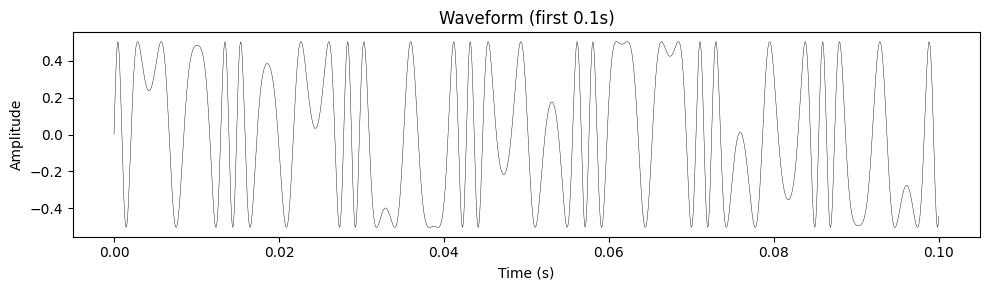

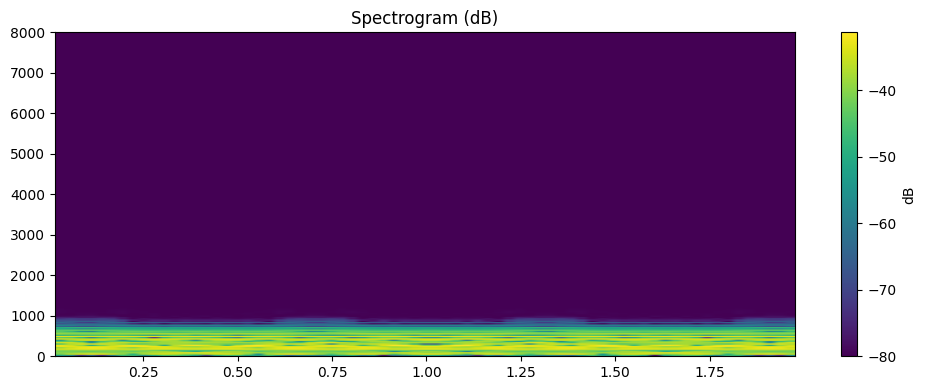

Prompt: a mellow flute tone
  Carrier freq:   440.20 Hz
  Modulator freq: 109.85 Hz
  Modulation idx: 3.51
  Amplitude:      0.40


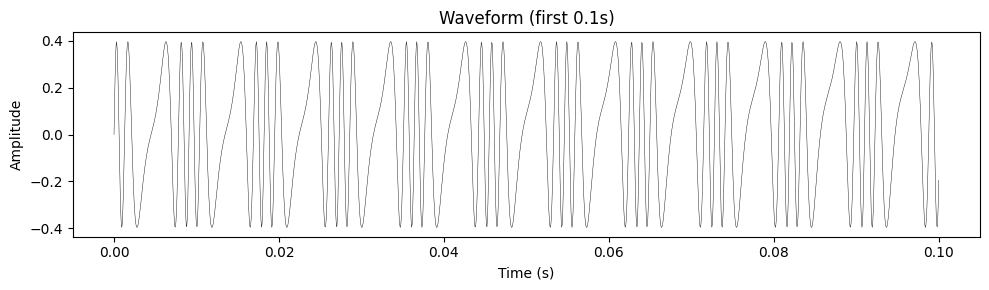

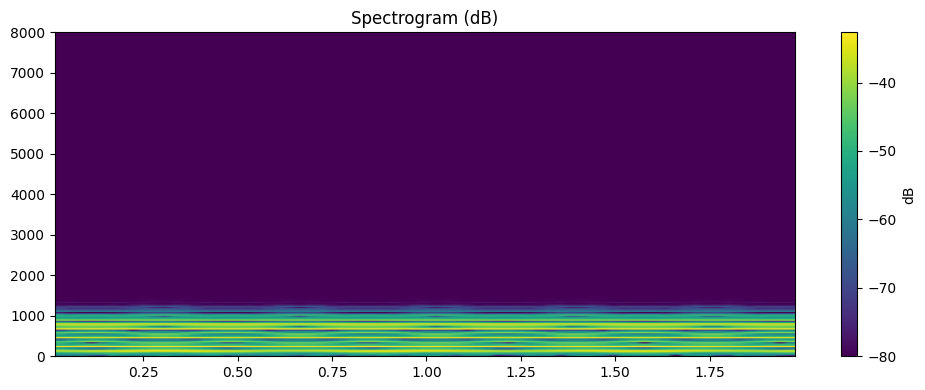

Prompt: a robotic beep
  Carrier freq:   599.50 Hz
  Modulator freq: 199.85 Hz
  Modulation idx: 8.00
  Amplitude:      0.50


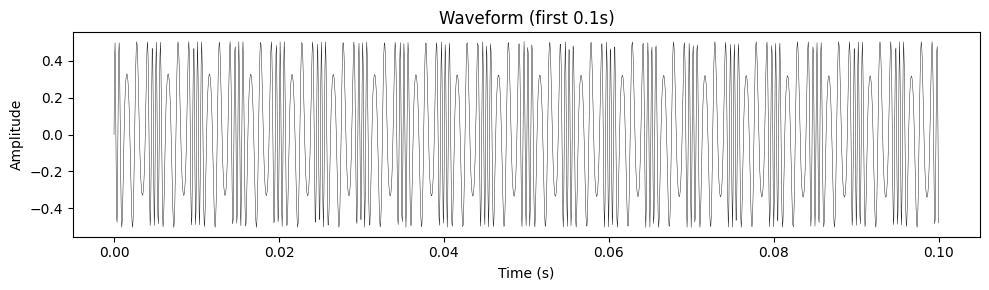

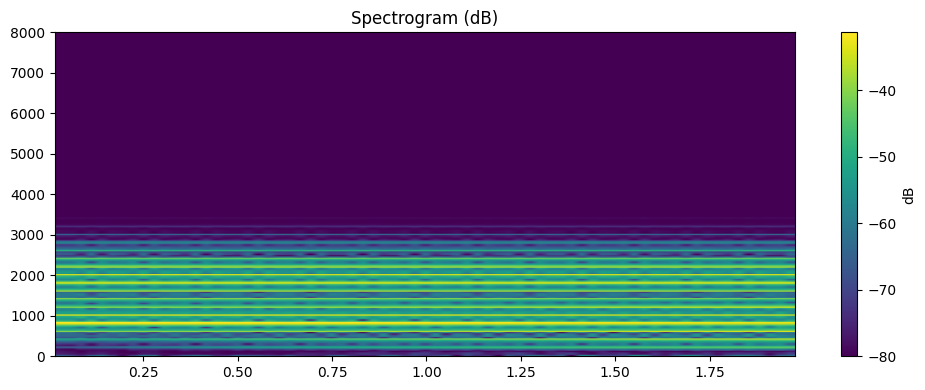

Prompt: a soft crackling fire
  Carrier freq:   250.30 Hz
  Modulator freq: 59.90 Hz
  Modulation idx: 7.50
  Amplitude:      0.30


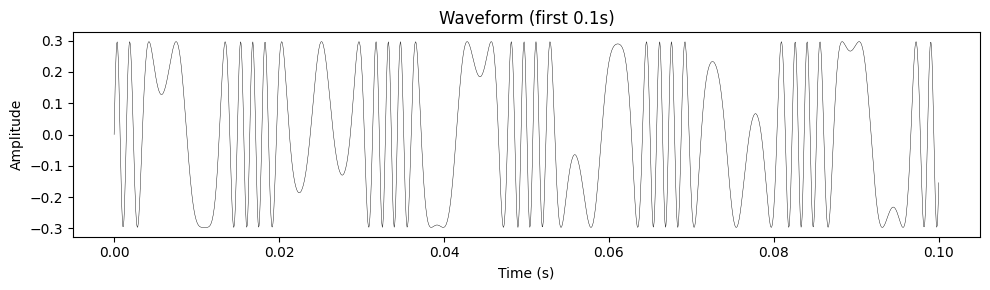

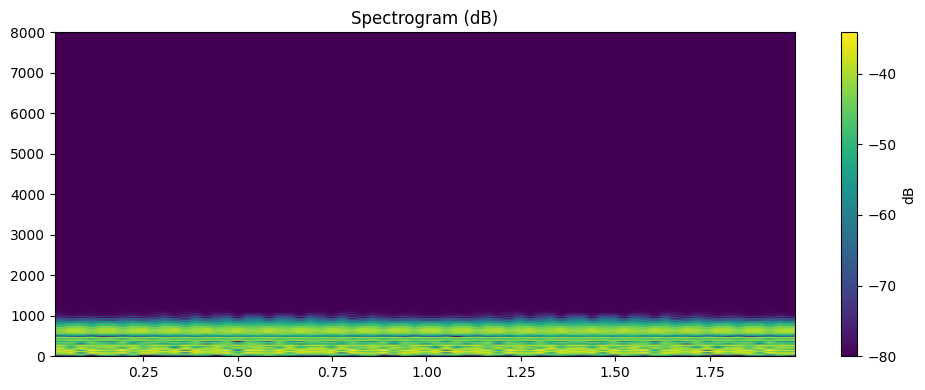

Prompt: a sharp bell tone
  Carrier freq:   477.31 Hz
  Modulator freq: 159.49 Hz
  Modulation idx: 5.47
  Amplitude:      0.45


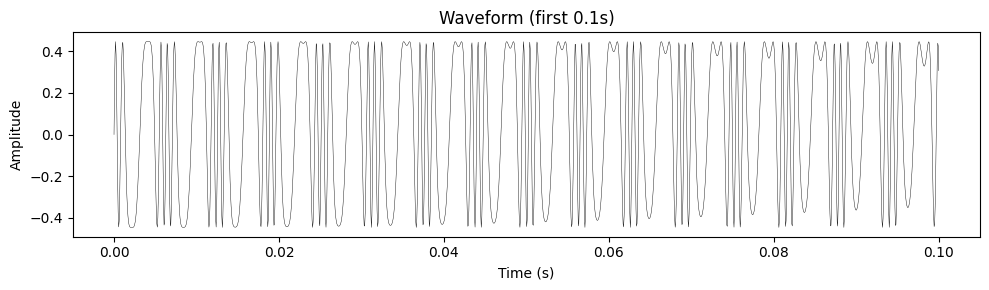

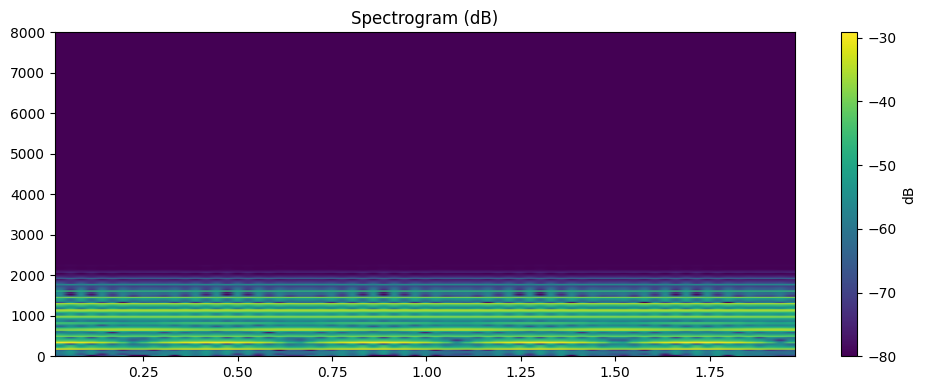

Prompt: a thunderous boom
  Carrier freq:   322.82 Hz
  Modulator freq: 139.76 Hz
  Modulation idx: 6.34
  Amplitude:      0.44


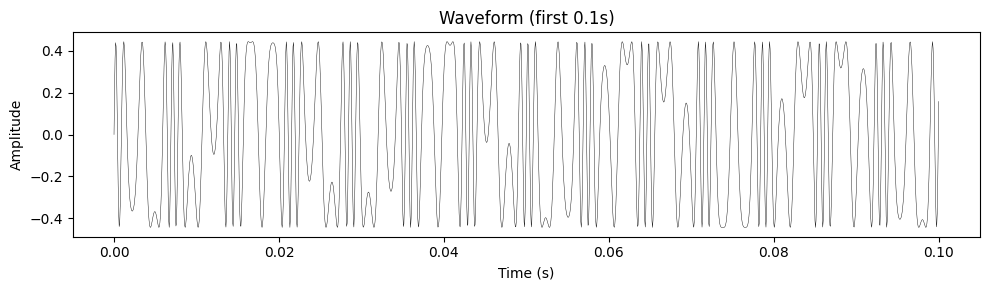

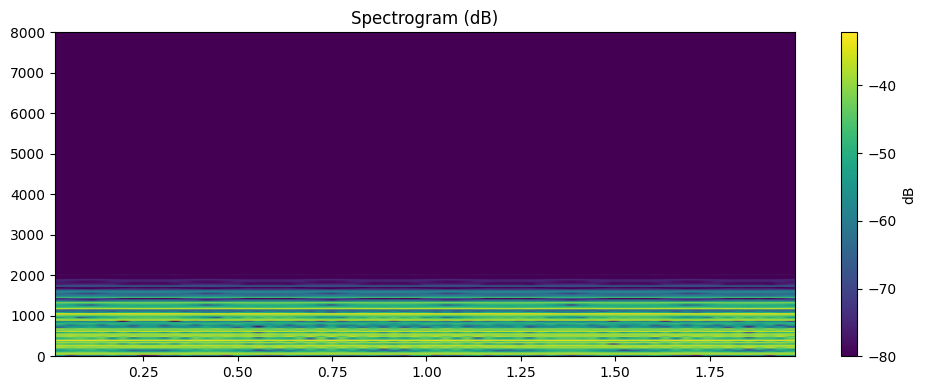

Prompt: a gentle whisper
  Carrier freq:   485.47 Hz
  Modulator freq: 175.15 Hz
  Modulation idx: 6.55
  Amplitude:      0.44


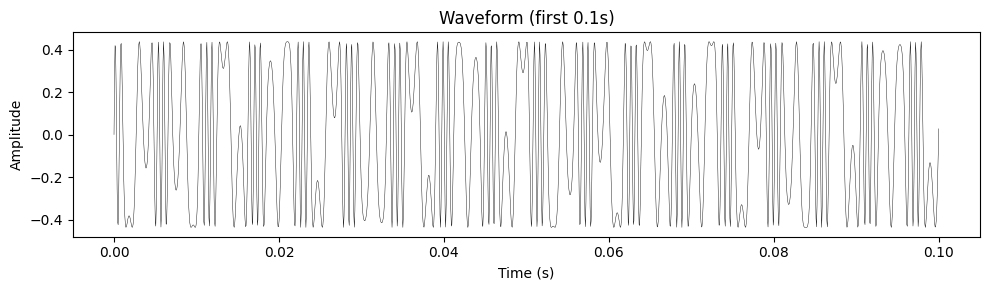

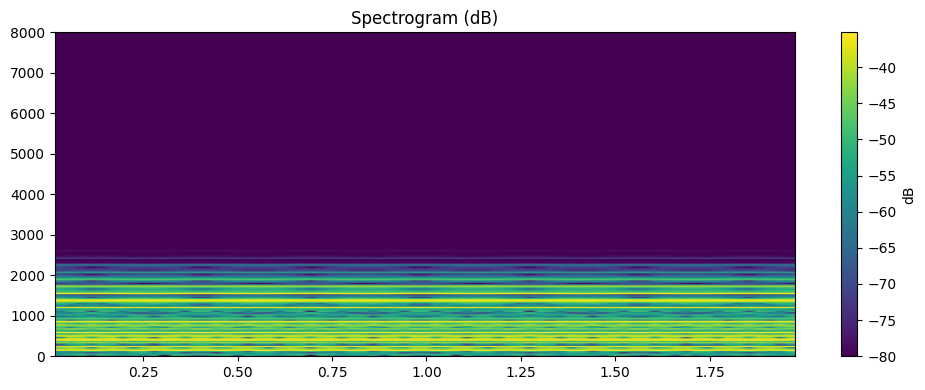

Prompt: an alien pulse
  Carrier freq:   330.22 Hz
  Modulator freq: 127.78 Hz
  Modulation idx: 6.59
  Amplitude:      0.51


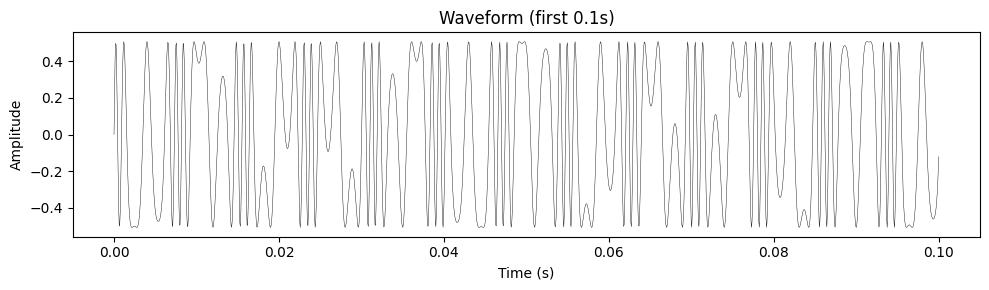

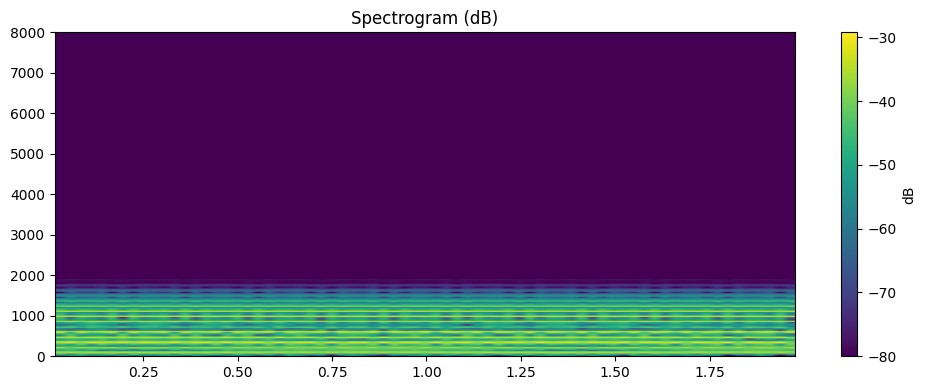

Prompt: a mechanical grinding
  Carrier freq:   425.28 Hz
  Modulator freq: 262.08 Hz
  Modulation idx: 6.53
  Amplitude:      0.49


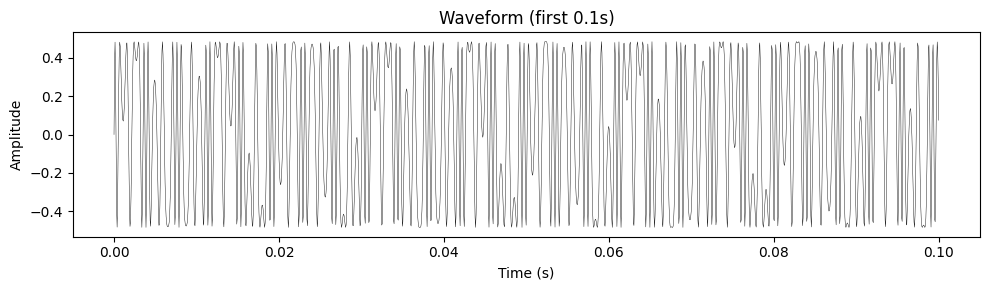

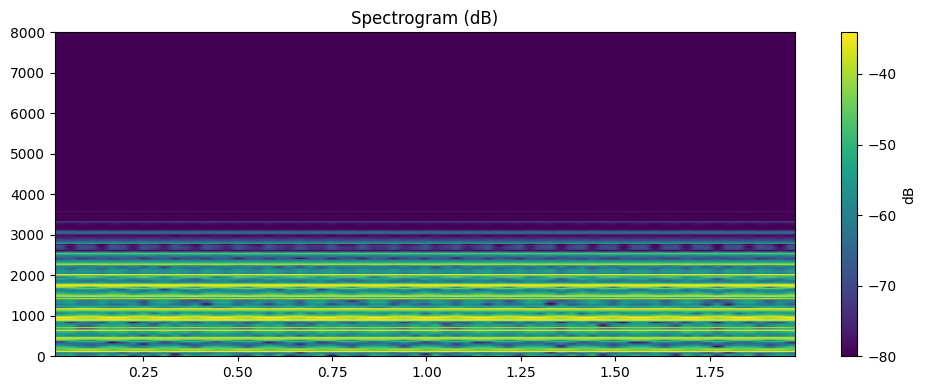

In [15]:
for example in train_data:
    display(generate_audio(example["prompt"], realnvp, processor, model_clap, duration=2.0))

# 📍 4.3 — Test the model on novel prompts
test_prompts = [
    "a sharp bell tone",
    "a thunderous boom",
    "a gentle whisper",
    "an alien pulse",
    "a mechanical grinding"
]

for prompt in test_prompts:
    display(generate_audio(prompt, realnvp, processor, model_clap, duration=2.0))

#**🎯 Final Remarks**

This notebook presents a RealNVP-based supervised mapping from CLAP embeddings to FM synthesis parameters.  
After training on a small manually annotated dataset of 5 prompt–parameter pairs, the invertible model learns to accurately reconstruct all training instances, achieving near-zero loss.

Evaluation on unseen prompts demonstrates good generalization:  
the model produces semantically plausible FM parameters for new descriptions such as **"a sharp bell tone"** and **"an alien pulse"**.

Compared to the MLP baseline, RealNVP introduces a more expressive and structured transformation.  
This opens the door to future extensions, such as latent-space interpolation and unsupervised regularization.

The RealNVP model proves to be a viable and interpretable alternative for language-to-sound parameter mapping.